# RIT-Intuit-Challenge 2017

## by - Sameer Raghuram

### Problem Statement
-------------------------
The number of couples who call it quits after a year or so is staggering. Among differences in opinion, life styles and other aspects, financial stress is one of the leading causes of breakups. In fact, experiencing money troubles is the 8th reason why couples break up (or divorce) in the US. At Intuit, we want to help couples stay together. The following exercise is aimed at coming up with a solution to help current or future couples stay together. To help our cause, we are providing you with a 2-year list of Mint transaction data from individuals who could likely be dating. We would like to increase the likelihood of people who have broken up (or were recently divorced) to have more successful current or future relationships.

# Method
-------------------

I parse the input csv files, and inititally create a overall data-frame containing all transactions

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind", 10), desat=.6)
sns.set_context(rc={'figure.figsize': (8, 4)})

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16}

D:\Users\Sameer\Anaconda3\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
D:\Users\Sameer\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:

'''
Import data from csv into an overall 
data-frame indexed by the auth_id of a user.
We will be using this data-frame to do our user-specific 
queries.

Map the user-number as it appears on the 
csv filename to their auth_id in the 
muser_map dictionary.
'''
user_map = {}

# A list of all the dataframes
# formed from the csv files.
data_frames = []
 
for i in range(100):
    
    url = "https://rawgit.com/intuit-recruiting/rit-challenge/tree/master/transaction-data"
    
    # Make sure the csv files are present :)
    filename = "./transaction-data/user-{}.csv".format(i)
    
    user_df = pd.read_csv(filename, index_col=['auth_id'])
    
    # Store auth_id in the dictionary
    user_map[i] = user_df.index[0]
    #print(user_df.index[0])
    
    # Strip the column names of leading and trailing whitespace. 
    user_df.rename(columns=lambda x: x.strip(), inplace=True)
    
    # Convert Date to datetime field    
    user_df['Date'] = pd.to_datetime(user_df.Date, infer_datetime_format=True, errors='coerce') 
        
    
    # Add to data frames
    data_frames.append(user_df)

# Collect all data frames into one table
df = pd.concat(data_frames)


This is a function I use extensively in the code coming up. It returns all the transactions pertaining to a user. Note - the users are indexed from 1 to 100. 

In [5]:
def get_user_transactions_all(user):
    '''
    This simply returns a data frame containing 
    transactions for the given user, indexed by
    date.
    '''
    # Defaults to 0 for now, must handle in the future
    user = user_map[user] if user in user_map else 0
    
    user_df = df.loc[user, :]
    #user_df.loc[user, 'auth_id'] = user_df.index
    user_df.set_index('Date', inplace=True)
    
    # Add columns for easier grouping-by-time operations
    user_df.loc[:, 'year'] = user_df.index.year.astype(int)
    user_df.loc[:, 'month'] = user_df.index.month.astype(int)
    user_df.loc[:, 'week'] = user_df.index.week.astype(int)
    user_df.loc[:, 'weekday'] = user_df.index.weekday    
    
    return user_df

In [6]:
get_user_transactions_all(12).head()

D:\Users\Sameer\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\Sameer\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Vendor,Amount,Location,year,month,week,weekday
Date,,,,,,,
2013-01-02,Amazon Order - Star Wars Figurine,-22.73,CA,2013,1,1,2.0
2013-01-02,Library Membership,-37.26,CA,2013,1,1,2.0
2013-01-02,Goods2 - ThinkGeek,-71.48,CA,2013,1,1,2.0
2013-01-03,Amazon Order - Biology Book,-69.48,CA,2013,1,1,3.0
2013-01-03,Coffee,-56.46,CA,2013,1,1,3.0


## Segregate user transactions involving expenditure and income.

In [8]:
def get_user_transactions_expenditure(user):
    '''
    Get all user transactions that involve expenditure.
    '''
    user_df = get_user_transactions_all(user)
    user_df = user_df.loc[user_df.Amount < 0, :]
    return user_df

def get_user_transactions_credits(user):
    '''
    Gets all records creditted to the users
    account
    '''
    user_df = get_user_transactions_all(user)
    user_df = user_df.loc[user_df.Amount > 0 or user_df.Vendor, :]
    return user_df

def get_user_income(user, period='Year'):
    userdf = get_user_transactions_credits(user)
    
    if period == 'Year':
        return userdf.resample('A').Amount.sum().mean()
    elif period == 'Month':
        return userdf.resample('M').Amount.sum().mean()



# Features To Explore:
----------------------------------------------------
- ### Compatibility
    * Get hobby transactions
    * Hobby transactions are classifiedinto broad categories
        + Music
        + Sports
        + Art
        + Entertainment
        + Video Games
    * Get total expenditure of a user in each of these hobby categories
    * This is the score we will work with
    * Two users are compatible if they have minimum delta across all categories
- ### Expecting Baby
    * Assign score based on number of transactions involving baby related items    
- ### Social Activity
    *  Assign score based on amount of transactions involving a bar or restaurant or movie hall.
- ### Indoor Activity
    * Assign score based on indoor related stuff - like dvd rentals, netflix subscriptions, food deliveries etc.            
- ### Fiscal problems
    * Get score of late payments and overdue notices etc
   
   
    

# Computing Features
------------------------------------
In the process of playing around with the data, and trying to extract some of the features, I realized that some of the queries (especially ones involving all users accross several categories) were taking a lot of time. To solve this, I employ a very well known object oriented design pattern - the Singleton. 

The Singleton interface I have created, computes amounts spent by all users on transactions grouped in several categories and stores it in a dictionary data structure. This dictionary can be used by all the other feature extraction methods that come forth.

The singleton makes it so that only a single instance of this dictionary exists at any given point, and all clients asking for this information receive it (the instance), and do not have to do the computation all over again. 

In [9]:
class CategoryScores:
    
    category_instance = None
    
    class __CategoryScores:
        
        def __init__(self):            
            # It might be useful to precompute, since queries take a lot of time
            # Hence, we are doing this whole singleton spiel 
            
            # There has got to be a better way of getting these keywords and categories.
            # But this should do, for now. 
            self.categories = {
                'Music': ['Concert', 'Guitar', 'guitar','music','piano'],
                'Sport': ['Sport','sports','NFL','NBA'],
                'Entertainment': ['movie', 'dvd'],
                'VideoGames':['game','playstation','xbox','nintendo','console'],
                'Books':['book','books','library'],
                'Art':['art','Art','Paint','canvas'],
                'Social': ['restaurant', 'bar', 'ticket', 'club', 'brewery'],
                'Indoor': ['on demand', 'food delivery', 'Netflix'],
                'Child': ['baby', 'hospital', 'maternity', 'prenatal', 'parental'],
                'Nerd': ['star wars', 'star trek'],
                'Student': ['science', 'biology', 'textbook', 'student'],
                'FiscalProblems': ['late fee', 'overdraft', 'negative balance', 'overdue', 'late']
                
            }            
            self.category_maps = None
            self.build_category_scores()
            
        def build_category_scores(self):
            if not self.category_maps:
                self.category_maps = {}
                # Build all category maps
                for user in range(100):
                    userdf = get_user_transactions_expenditure(user)
                    user_category_map = {}
                    
                    for key in self.categories.keys():                        
                        search_string = "|".join(self.categories[key])        
                        user_category_map[key] = int(userdf[userdf.Vendor.str.contains(search_string, case=False)]
                                                     .Amount.abs().sum())
                        
                    self.category_maps[user]  = user_category_map
    def __new__(cls): 
        if not CategoryScores.category_instance:
            CategoryScores.category_instance = CategoryScores.__CategoryScores()
        return CategoryScores.category_instance
    
    def __getattr__(self, name):
        return getattr(self.category_instance, name)

# Adding Features
------------------------------
In order to add features, I need a single data frame which is indexed by a users auth_id, and has columns containing scores or other metrics for features. I have again chosen to represent this singular data frame as a singleton (called UserFeatures).

In [10]:
class UserFeatures:
    instance = None
    
    class __UserFeatures:
        
        def __init__(self):
            self.user_features_data_frame = pd.DataFrame(index=df.index.unique())
            
        def get(self):
            return self.user_features_data_frame
            
    def __new__(cls): 
        if not UserFeatures.instance:
            UserFeatures.instance = UserFeatures.__UserFeatures()
        return UserFeatures.instance
    
    def __getattr__(self, name):
        return getattr(self.instance, name)
    
    def __setattr__(self, name):
        return setattr(self.instance, name)           
            

## Decorator for feature addion
----------------------------------------------
The following block is a nice design pattern commonly deployed in python wherein a functions functionality can be extended by 'decorating' it with another function. In my case, I have made the add_feature decorator such that it adds a feature to all the users present in the UserFeatures singleton. 

In [11]:
def add_feature(add_feature_func):
    '''
    Decorator function that returns a data-frame 
    that contains a column representing  the 
    feature implemented by the feature_func function.
    
    The feature func should be a function over users and
    return a single value, and should also have an optional
    kwarg specifying the name of the resultant feature column.
    '''
    
    def __add_feature_to_data_frame(column_name):
        name = column_name
        #print(name)
        user_features = UserFeatures()
        user_features.user_features_data_frame.loc[:,name] = add_feature_func(name)
    
    return __add_feature_to_data_frame       
        

## Is the user expecting a newborn ? 
The following code demonstrates the features of the design decisions I have chosen to make. 
<code>is_expecting(user)</code> checks if the user has any transactions pertaining to newborns or maternity care. 
<code>add_is_expecting</code> uses is_expecting and the <code>@add_feature</code> decorator syntax sugar to add this feature to our features table

In [12]:
def is_expecting(user):
    '''
    Assigns the user a score on whether the user is a parent of 
    a new born or expecting a baby
    '''
    # Get user expenditure in a data frame
    
    all_users_category_scores = CategoryScores().category_maps  
    is_expecting_ans = 1 if all_users_category_scores[user]['Child'] > 0 else 0
    #userdf = userdf[userdf.Vendor.str.contains('Baby|Babies|Maternity|Prenatal')].Amount.abs().sum()
        
    return is_expecting_ans

@add_feature
def add_is_expecting(column_name):
    
    return [is_expecting(user) for user in range(100)]

In [13]:
add_is_expecting('ExpectingChild')


D:\Users\Sameer\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\Sameer\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
UserFeatures().user_features_data_frame.head(10)

,ExpectingChild,MostCompatible
auth_id,,
624,1,3028
63891,1,3122
89593,1,3122
99842,1,3028
57556,1,3028
20128,1,624
37948,1,3122
19209,1,624
83049,1,624


# User Compatibility
---------------------------------
In order to get a score for the compatibility between users, I have used transactions made by them for hobbies and interests as a measuring stick. We compute the euclidean distance between two users (for these hoobies and interests) to arrive at a score that represents how close two are in these terms. 

I can then use this to add a feature in our features data-frame that shows the auth_id of the user most compatible with the current user. 

In [15]:
   
def get_hobby_distance(user1_category_map, user2_category_map):
    distance = 0
    hobbies = ['Music', 'Sport', 'Entertainment', 'Art', 'Books', 'VideoGames']
    for key in hobbies:
        distance += (abs(user1_category_map[key] - user2_category_map[key]) ** 2)
    return distance ** (1/2)


def get_most_compatible(user):
    all_users_category_scores = CategoryScores()
    user_category_map = all_users_category_scores.category_maps[user]
    distances = []    
    for other_user in range(100):
        if not other_user == user:
            other_user_map = all_users_category_scores.category_maps[other_user]
            other_user_distance = get_hobby_distance(user_category_map, other_user_map)
            distances.append([other_user, other_user_distance])
    # Sort by the distance
    return max(distances, key=lambda x: x[1])

@add_feature
def add_most_compatible(column_name):
    return [user_map[get_most_compatible(user)[0]] for user in range(100)]
    

In [16]:
add_most_compatible('MostCompatible')

In [17]:
UserFeatures().get().sample(5)

,ExpectingChild,MostCompatible
auth_id,,
99128,1,624
1882,1,3122
16910,1,3122
28337,1,624
81829,1,624


## Exploring social nature
Okay. Lets be honest - this is not a good rationale behind deciding whether a person is introverted or not. I don't think anyone can even be labelled as a clear introvert or extrovert. But, that is besides the point. The point here is to show how features can continuosly be added to augment the model

In [25]:
def is_introvert_or_extrovert(user):
    all_users_category_scores = CategoryScores()
    user_category_map = all_users_category_scores.category_maps[user]
    score_introvert = user_category_map['Indoor'] + user_category_map['VideoGames']
    score_extrovert = user_category_map['Social'] + user_category_map['Sport']
    
    if score_introvert > score_extrovert:
        return "Introvert"
    elif score_extrovert > score_introvert:
        return "Extrovert"
    else:
        return "Neither"
    
def is_most_compatible_introvert_or_extrovert(user):
    most_compat = get_most_compatible(user)[0]
    return is_introvert_or_extrovert(most_compat)

@add_feature
def add_social_type_feature(column_name):
    return [is_introvert_or_extrovert(user) for user in range(100)]

@add_feature
def add_social_type_feature_most_compat(column_name):
    return [is_most_compatible_introvert_or_extrovert(user) for user in range(100)]


In [20]:
add_social_type_feature('IntrovertOrExtrovert')

In [22]:
UserFeatures().get().sample(10)

,ExpectingChild,MostCompatible,IntrovertOrExtrovert
auth_id,,,
56930,1,3028,Extrovert
16910,1,3122,Extrovert
28328,1,3028,Extrovert
99128,1,624,Introvert
24694,1,624,Introvert
72851,1,3122,Extrovert
96265,1,624,Extrovert
91528,1,624,Introvert
3028,1,3122,Extrovert


In [26]:
add_social_type_feature_most_compat('MostCompatibleVert')

In [33]:
UserFeatures().get().sample(10)

,ExpectingChild,MostCompatible,IntrovertOrExtrovert,MostCompatibleVert
auth_id,,,,
66483,0,3028,Extrovert,Extrovert
28143,1,3122,Extrovert,Extrovert
53897,1,3028,Extrovert,Extrovert
28816,1,3028,Extrovert,Extrovert
9340,0,624,Extrovert,Extrovert
94976,1,3122,Extrovert,Extrovert
76016,0,624,Introvert,Extrovert
31277,1,3122,Extrovert,Extrovert
55836,1,3028,Extrovert,Extrovert


## Is the user a student? 
Transactions are examined for certain keywords (like student loans, textbooks) to determine if the user is likely a student or not

In [34]:
def is_student(user):
    all_users_category_scores = CategoryScores()
    user_category_map = all_users_category_scores.category_maps[user]
    return 1 if user_category_map['Student'] > 0 else 0

@add_feature
def add_student_feature(column_name):
    return [is_student(user) for user in range(100)]

In [35]:
add_student_feature('IsStudent')

In [37]:
UserFeatures().get().sample(10)

,ExpectingChild,MostCompatible,IntrovertOrExtrovert,MostCompatibleVert,IsStudent
auth_id,,,,,
85770,0,3028,Extrovert,Extrovert,1
9367,0,624,Introvert,Extrovert,1
55836,1,3028,Extrovert,Extrovert,0
23752,1,3122,Extrovert,Extrovert,1
19209,1,624,Extrovert,Extrovert,1
43085,1,624,Extrovert,Extrovert,1
94765,1,624,Extrovert,Extrovert,1
50068,1,3122,Extrovert,Extrovert,0
44675,1,624,Introvert,Extrovert,0


## Bar activity by weekday
The following plot is based on a feature I hypothesised (maybe from personal experience :P) about activity post a break-up. My reasoning was that visits to liquor stores or bars during weekends would mostly be social in nature, while the same on weekdays would suggest certain issues the user is going through. 

In [39]:
    
def get_bar_activity_by_day(user):
    '''
    Gets the distribution of money spent by a
    user in bars over weekdays.
    The idea here is that visits to the bar during 
    weekends is for social purposes. During weekdays
    maybe the user is suffering from issues. 
    Again. No judgements here. Just going by personal experiece :P
    '''
    userdf = get_user_transactions_expenditure(user)
    #userdf.resample('')
    userdf = userdf[userdf.Vendor.str.contains('Bar|drinks|liquor')].groupby('weekday').Amount.sum().abs()
    return userdf
    
def plot_bar_activity(user):
    bar_activity_weekday_counts = get_bar_activity_by_day(user)
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    if(len(bar_activity_weekday_counts) > 0):
        bar_activity_weekday_counts.index = weekdays
        plot = bar_activity_weekday_counts.plot(kind='bar')
        plot.set_title('Visits to the bar by weekday', fontdict=font)
        ax = plot.axes
        ax.set_xlabel('Weekday')
        ax.set_ylabel('Money Spent')


D:\Users\Sameer\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\Sameer\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


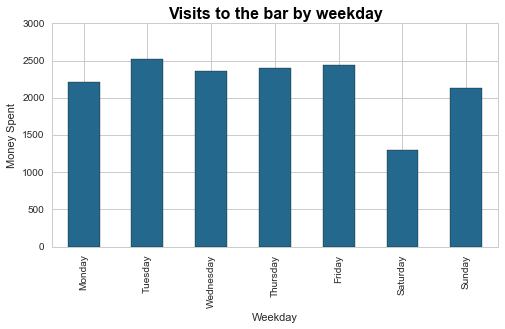

In [41]:
plot_bar_activity(7)

# Conclusion
-------------------------
This challenge was quite enlightning for someone like me, as an introduction to the challenges faced in gathering intelligence from data. I knew from the outset that whatever I would end up doing would just be a very naive attempt at feature extraction. So what I sought out to do was to build a clean system to interact with, and reason about the data. In this current design, I would not have to (I hope) change too much of the code to add more logic to the actual feature extraction.

In the process of making this notebook, I got to learn quite a bit of the python pandas, numpy and matplotlib libraries. These software projects seem to have a very fun, engaging and thriving community that backs them. This also gave me a small peek into the challenges of Data Science. I look forward to playing around with some of the Kaggle challenges to explore this further !